In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
workDir = '/home/chantal/Chazy/Bulk/ITS/data/'
figDir = '/home/chantal/Chazy/Bulk/ITS/figs/'

physeqDir = '/home/chantal/Chazy/data/phyloseq/ITS/'
physeqBulk = 'bulk-core'


nprocs = 20

In [4]:
%%R
library(phyloseq)
library(tidyr)
library(plyr); library(dplyr)
library(DESeq2)
library(foreach)
library(doParallel)
library(ggplot2)
library(gridExtra)
library(reshape2)
library(RColorBrewer)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/f

#### Read in sample metadata and OTU table

In [4]:
%%R

F = file.path(physeqDir, physeqBulk)
print(F)
physeq.Bulk = readRDS(F)
physeq.Bulk.m = physeq.Bulk %>% sample_data
physeq.Bulk = prune_samples((physeq.Bulk.m$Land_Management != "PAS"),
                           physeq.Bulk)

physeq.Bulk = subset_taxa(physeq.Bulk, Rank1=="k__Fungi")

physeq.Bulk.m = physeq.Bulk %>% sample_data


physeq.Bulk

[1] "/home/chantal/Chazy/data/phyloseq/ITS//bulk-core"
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2247 taxa and 176 samples ]
sample_data() Sample Data:       [ 176 samples by 24 sample variables ]
tax_table()   Taxonomy Table:    [ 2247 taxa by 7 taxonomic ranks ]


In [7]:
%%R
mdf = psmelt(physeq.Bulk)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2247 taxa and 44 samples ]
sample_data() Sample Data:       [ 44 samples by 24 sample variables ]
tax_table()   Taxonomy Table:    [ 2247 taxa by 7 taxonomic ranks ]


In [11]:
%%R
mdf %>% filter(Abundance != 0) %>% group_by(Land_Management) %>% summarise(sum(Abundance))

Source: local data frame [4 x 2]

  Land_Management sum(Abundance)
           (fctr)          (dbl)
1             NTH         200618
2             NTR         262713
3             PTH         255625
4             PTR         293922


In [16]:
%%R
mdf %>% filter(Abundance != 0) %>% group_by(Land_Management) %>% summarise(counts = n_distinct(OTU))

Source: local data frame [4 x 2]

  Land_Management counts
           (fctr)  (int)
1             NTH   1363
2             NTR   1343
3             PTH   1314
4             PTR   1178


In [9]:
%%R
tail(mdf)

            OTU         Sample Abundance    Full.sample Fraction PrimerF
395467 OTU.9997     June.PTR.2         0     June.PTR.2       NA  nBITSf
395468 OTU.9997     Sept.PTR.4         0     Sept.PTR.4       NA  nBITSf
395469 OTU.9997     Sept.NTR.3         0     Sept.NTR.3       NA  nBITSf
395470 OTU.9997 Oct.NTR.1.2015         0 Oct.NTR.1.2015       NA  nBITSf
395471 OTU.9997     Sept.PTH.1         0     Sept.PTH.1       NA  nBITSf
395472 OTU.9997 Aug.NTH.1.2015         0 Aug.NTH.1.2015       NA  nBITSf
       PrimerR Barcode Rev.index Fwd.index Treatment Day Pool     Experiment
395467   58A2r     163  gcgtatac  tagcgagt       PTR  NA    4 Chazy.ITS.Bulk
395468   58A2r     103  ctcgactt  ggatatct       PTR  NA    4 Chazy.ITS.Bulk
395469   58A2r      94  tatagcga  cgtgagtg       NTR  NA    4 Chazy.ITS.Bulk
395470   58A2r     158  atagtacc  cgtgagtg       NTR  NA    5 Chazy.ITS.Bulk
395471   58A2r      96  tatagcga  gacaccgt       PTH  NA    4 Chazy.ITS.Bulk
395472   58A2r     119  tag

In [6]:
%%R
get_l2fc = function(physeq.obj, sparsity_threshold) {
    physeq.md = sample_data(physeq.obj)
   
    p = filter_taxa(physeq.obj, function(x) sum(x > 0) > sparsity_threshold * length(x), TRUE)
 
    dds = phyloseq_to_deseq2(p, ~ Till)
    dds = DESeq(dds, quiet = TRUE, fitType = "local")
        
    theta = 1
    r = results(dds, independentFiltering = FALSE)
    r$OTU = rownames(r)
   
    d = data.frame(r[, c("OTU","log2FoldChange", "lfcSE", "padj")])

   # d$padj = p.adjust(p, method = "BH")
    TT = data.frame(tax_table(p))
    TT$OTU = rownames(TT)
    d = left_join(d, TT)


    d
}

In [7]:
%%R
# adding range of sparsity thresholds (all pairwise)

sdms = as.data.frame(seq(0.05,0.95,0.05))
colnames(sdms) = 'sparsity_threshold'
#cat('Number of pairwise combinations of variables:', sdms.P %>% nrow, '\n\n')
head(sdms) 

  sparsity_threshold
1               0.05
2               0.10
3               0.15
4               0.20
5               0.25
6               0.30


In [8]:
%%R
registerDoParallel(8)

df.l2fc = tbl_df(mdply(sdms, 
                       get_l2fc, 
                       .parallel = TRUE, 
                       physeq.obj = physeq.Bulk))
df.l2fc

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:1

Source: local data frame [3,648 x 12]

   sparsity_threshold       OTU log2FoldChange     lfcSE         padj    Rank1
                (dbl)     (chr)          (dbl)     (dbl)        (dbl)   (fctr)
1                0.05  OTU.6089     -2.5222263 0.9178653 1.421236e-02 k__Fungi
2                0.05  OTU.6711      2.8812759 0.7240328 2.447177e-04 k__Fungi
3                0.05  OTU.2605      1.8032284 0.5512317 3.034886e-03 k__Fungi
4                0.05  OTU.6041     -0.4527828 0.9590434 7.165685e-01 k__Fungi
5                0.05  OTU.6291      0.2545411 0.6936291 7.815062e-01 k__Fungi
6                0.05  OTU.9364     -3.2264654 0.7592088 8.300441e-05 k__Fungi
7                0.05   OTU.586      2.4276199 0.5490232 4.245290e-05 k__Fungi
8                0.05 OTU.19007     -2.1647255 1.0439484 7.076130e-02 k__Fungi
9                0.05   OTU.469     -0.5265921 1.0394163 7.008717e-01 k__Fungi
10               0.05 OTU.28809      1.5129387 1.0383014 2.173264e-01 k__Fungi
..           

In [9]:
%%R
summarise(df.l2fc,
  meanl2fc = mean(log2FoldChange, na.rm = TRUE))

Source: local data frame [1 x 1]

    meanl2fc
       (dbl)
1 -0.4714529


In [10]:
%%R
summarise(df.l2fc,
  sdl2fc = sd(log2FoldChange, na.rm = TRUE))

Source: local data frame [1 x 1]

    sdl2fc
     (dbl)
1 2.274159


In [11]:
%%R
levels(physeq.Bulk.m$Till)

[1] "N" "P"


In [12]:
%%R
df.l2fc$padj2 = p.adjust(df.l2fc$padj, method = "BH")

In [13]:
%%R
df.l2fc$Till[df.l2fc$log2FoldChange > 0] = "T"
df.l2fc$Till[df.l2fc$log2FoldChange <0] = "N"

In [14]:
%%R
write.table(df.l2fc, "data/l2fc_TillCompiled", row.names = FALSE, sep = ",")

In [4]:
%%R
df.l2fc = read.table('data/l2fc_TillCompiled', sep =',', header = TRUE)

In [5]:
%%R
head(df.l2fc)

  sparsity_threshold      OTU log2FoldChange     lfcSE         padj    Rank1
1               0.05 OTU.6089     -2.5222263 0.9178653 1.421236e-02 k__Fungi
2               0.05 OTU.6711      2.8812759 0.7240328 2.447177e-04 k__Fungi
3               0.05 OTU.2605      1.8032284 0.5512317 3.034886e-03 k__Fungi
4               0.05 OTU.6041     -0.4527828 0.9590434 7.165685e-01 k__Fungi
5               0.05 OTU.6291      0.2545411 0.6936291 7.815062e-01 k__Fungi
6               0.05 OTU.9364     -3.2264654 0.7592088 8.300441e-05 k__Fungi
             Rank2             Rank3           Rank4           Rank5
1  p__unidentified   c__unidentified o__unidentified f__unidentified
2  p__unidentified   c__unidentified o__unidentified f__unidentified
3  p__unidentified   c__unidentified o__unidentified f__unidentified
4 p__Basidiomycota c__Agaricomycetes   o__Agaricales  f__Agaricaceae
5 p__Basidiomycota c__Agaricomycetes   o__Agaricales  f__Agaricaceae
6 p__Basidiomycota c__Agaricomycetes    o__Bole

In [6]:
%%R
r = filter(df.l2fc, padj2 <=0.10)
print(length(unique(r$OTU)))
print(length(df.l2fc$OTU))

[1] 405
[1] 3648


In [7]:
%%R

padj.cutoff = 0.10

df.l2fc.rejH = df.l2fc %>%
    filter(padj2 <= padj.cutoff) %>%
    group_by(sparsity_threshold) %>%
    summarize(n_reject_hypo = n()) %>%
    ungroup

df.l2fc.rejH %>% head(n=6)

Source: local data frame [6 x 2]

  sparsity_threshold n_reject_hypo
               (dbl)         (int)
1               0.05           389
2               0.10           323
3               0.15           269
4               0.20           225
5               0.25           180
6               0.30           158


In [8]:
%%R

padj.cutoff = 0.10

df.l2fc.rejH.s = df.l2fc %>%
    filter(padj2 < padj.cutoff) %>%
    group_by(sparsity_threshold) %>%
    summarize(n_reject_hypo = n()) %>%
    ungroup

df.l2fc.rejH.s %>%  as.data.frame

   sparsity_threshold n_reject_hypo
1                0.05           389
2                0.10           323
3                0.15           269
4                0.20           225
5                0.25           180
6                0.30           158
7                0.35           140
8                0.40           124
9                0.45           111
10               0.50            90
11               0.55            80
12               0.60            73
13               0.65            65
14               0.70            59
15               0.75            50
16               0.80            44
17               0.85            37
18               0.90            31
19               0.95            27


In [9]:
%%R
# max number of rejected hypos 
max.rejH = df.l2fc.rejH.s %>%
    arrange(desc(n_reject_hypo)) %>%
    head(n=1)
max.rejH = max.rejH$sparsity_threshold
max.rejH

[1] 0.05


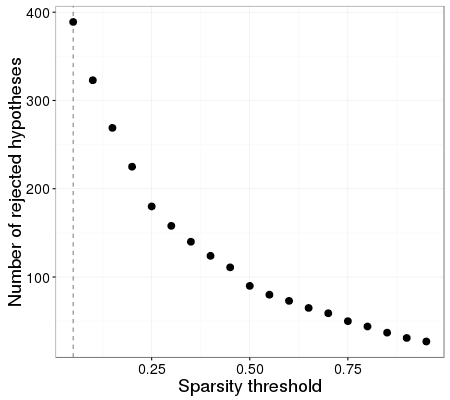

In [10]:
%%R -w 450 -h 400

ggplot(df.l2fc.rejH.s, aes(sparsity_threshold, n_reject_hypo)) +
    geom_point(size=3) +
    geom_vline(xintercept=max.rejH, linetype='dashed', alpha=0.5) +
    labs(x='Sparsity threshold', y='Number of rejected hypotheses') +
    theme_bw() +
    theme(
        text = element_text(size=18),
        axis.title.y = element_text(vjust=1)
        )

In [11]:
%%R
df.l2fc.f = df.l2fc %>%
    filter(sparsity_threshold == 0.05) 

df.l2fc.f %>% nrow

[1] 737


In [12]:
%%R #-i workDir
# Writing out l2fc table

outFile = 'data/l2fc_Till.txt'
write.table(df.l2fc.f, 'data/l2fc_Till.txt', sep='\t', quote=FALSE, row.names=FALSE)

In [5]:
%%R
df.l2fc = read.table('data/l2fc_Till.txt', sep='\t', header = TRUE)

In [6]:
%%R
df.l2fc$Rank2 = gsub("p__", "", df.l2fc$Rank2)
df.l2fc$Rank3 = gsub("c__", "", df.l2fc$Rank3)
df.l2fc$Rank4 = gsub("o__", "", df.l2fc$Rank4)
df.l2fc$Rank5 = gsub("f__", "", df.l2fc$Rank5)
df.l2fc$Rank6 = gsub("g__", "", df.l2fc$Rank6)
df.l2fc$Rank7 = gsub("s__", "", df.l2fc$Rank7)

In [7]:
%%R
print(length(df.l2fc$OTU))
print(length(unique(df.l2fc$OTU)))

[1] 737
[1] 737


In [8]:
%%R
df.l2fc %>% filter(padj2 <=0.10) %>% group_by(Rank6, Till) %>% summarise(resp = n()) %>% ungroup %>% arrange(-resp) %>%
         as.data.frame

               Rank6 Till resp
1       unidentified    N   80
2               <NA>    N   79
3               <NA>    T   37
4       unidentified    T   32
5        Penicillium    N    7
6           Fusarium    N    6
7        Mortierella    T    6
8        Mortierella    N    5
9         Acremonium    T    4
10      Myrmecridium    N    4
11       Trichoderma    N    4
12      Cryptococcus    N    3
13       Metarhizium    N    3
14       Penicillium    T    3
15     Schizothecium    N    3
16       Talaromyces    T    3
17       Trichoderma    T    3
18        Acremonium    N    2
19     Articulospora    N    2
20     Camarosporium    N    2
21           Candida    N    2
22        Cercophora    T    2
23       Coniochaeta    T    2
24         Exophiala    N    2
25         Ganoderma    N    2
26       Ilyonectria    N    2
27         Lipomyces    N    2
28     Monographella    N    2
29       Myrothecium    N    2
30            Peziza    T    2
31           Phallus    N    2
32      

In [9]:
%%R
resp = df.l2fc %>% filter(padj2 <=0.10) %>% group_by(Till) %>% summarise(resp = n())
resp %>% as.data.frame

  Till resp
1    N  266
2    T  123


In [10]:
%%R
test = matrix(c(123, 614, 266, 471), nrow =2, ncol = 2)
colnames(test) = c('Till', 'NT')
rownames(test) = c('responders', 'non-responders')
test

               Till  NT
responders      123 266
non-responders  614 471


In [11]:
%%R
fisher.test(test)


	Fisher's Exact Test for Count Data

data:  test
p-value < 2.2e-16
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.2751884 0.4562361
sample estimates:
odds ratio 
 0.3549646 



In [12]:
%%R 
(266+123)/737

[1] 0.5278155


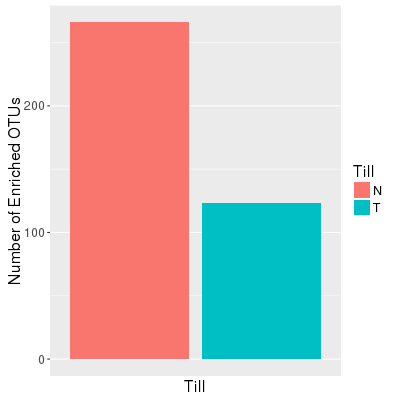

In [13]:
%%R -w 400 -h 400
p = ggplot(data = resp, aes(x = Till, y = resp, fill = Till)) +
    geom_bar(stat = 'identity') + 
    theme(text = element_text(size=16)) + ylab("Number of Enriched OTUs") + scale_x_discrete(breaks=NULL)
p

In [14]:
%%R
ggsave(filename = "data/figs/EnrichedNumoverTime.jpg", plot = p, width =4, height =5)

####Function arguments

In [15]:
%%R
colors.1 = c("#6d7000",
"#0258dd",
"#37a411",
"#8163ed",
"#c1ab00",
"#017de1",
"#ffa43a",
"#ff8aff",
"#009b4d",
"#fd47b8",
"#00a272",
"#f92b5d",
"#65dab9",
"#a90614",
"#01a0bd",
"#f36026",
"#8e6794",
"#c5cb8b",
"#a30a4b",
"#c3a573",
"#7c3c6e",
"#ff6167",
"#925349",
"#ff8aa5",
"#8c3913")

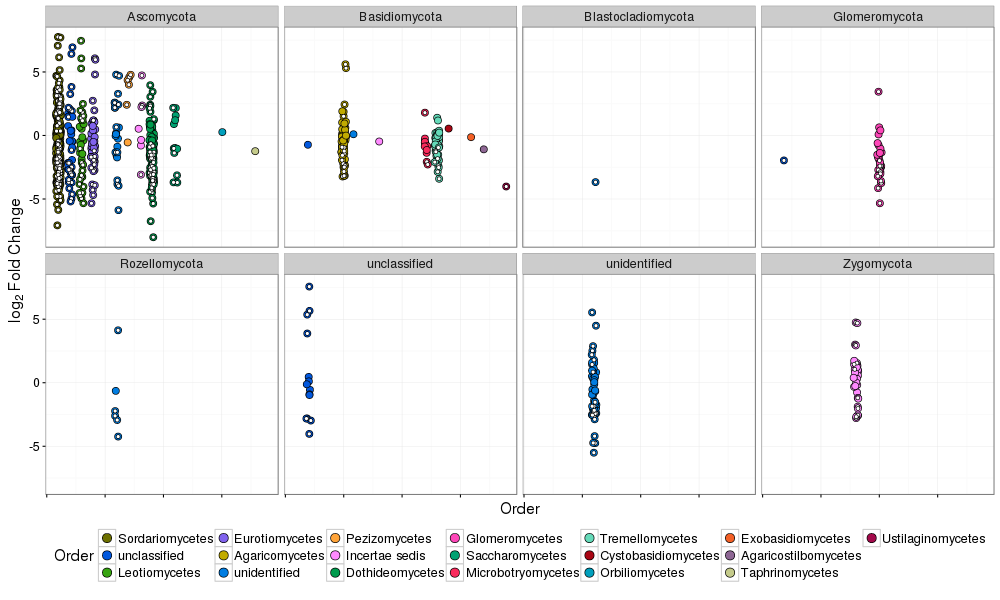

In [46]:
%%R -w 1000 -h 600
d = df.l2fc
FDR = 0.10

d$Rank3 = as.character(d$Rank3)
d$Rank3[is.na(d$Rank3)] = "unclassified"
d$Rank2[is.na(d$Rank2)] = "unclassified"

d$Rank3= factor(d$Rank3)

max.l2fc = ddply(d, .(Rank3), summarize, M = max(log2FoldChange))
d$Rank3 = factor(d$Rank3, max.l2fc[order(-max.l2fc$M),]$Rank3)

M = max(as.numeric(d$Rank3), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank3)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2


p = ggplot(d, aes(x = x.jitter, y = log2FoldChange, fill = Rank3))

p = p + geom_point(alpha = 1.00, shape = 21, size = 3)

p = p + scale_fill_manual(values = colors.1)

p = p + geom_point(data = subset(d, padj2 <= 0.10), fill = "white", shape = 21, size = 1.5)

#p = p + geom_hline(y = 1.3)


p = p + theme_bw() + theme(axis.text.x = element_blank())

p = p + labs(x = "Order", fill = "Order")


p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(fill = guide_legend(override.aes = list(size=4), nrow = 3))  +
    theme(text = element_text(size=16)) #+ guides(color = FALSE)

p = p + facet_wrap(~Rank2, ncol = 4) +
    theme(legend.position = 'bottom')

p

In [47]:
%%R
ggsave('data/figs/Till_phylaLFC.jpg', width = 14, height = 8)

In [17]:
%%R
df.P = df.l2fc %>% group_by(Rank2, Till) %>% mutate(ntax = n()) %>% filter(padj2 <= 0.10) %>% mutate(resp = n()) 
head(df.P)

Source: local data frame [6 x 16]
Groups: Rank2, Till [4]

  sparsity_threshold      OTU log2FoldChange     lfcSE         padj    Rank1
               (dbl)   (fctr)          (dbl)     (dbl)        (dbl)   (fctr)
1               0.05 OTU.6089      -2.522226 0.9178653 1.421236e-02 k__Fungi
2               0.05 OTU.6711       2.881276 0.7240328 2.447177e-04 k__Fungi
3               0.05 OTU.2605       1.803228 0.5512317 3.034886e-03 k__Fungi
4               0.05 OTU.9364      -3.226465 0.7592088 8.300441e-05 k__Fungi
5               0.05  OTU.586       2.427620 0.5490232 4.245290e-05 k__Fungi
6               0.05 OTU.5914      -2.428845 0.6156688 2.786736e-04 k__Fungi
Variables not shown: Rank2 (chr), Rank3 (chr), Rank4 (chr), Rank5 (chr), Rank6
  (chr), Rank7 (chr), padj2 (dbl), Till (fctr), ntax (int), resp (int)


In [18]:
%%R
df.P2 = df.P %>% ungroup %>% select(Rank2, ntax, resp, Till) %>% unique() 
df.P2$Perc_resp = df.P2$resp/df.P2$ntax

df.P2 %>% arrange(Rank2)

Source: local data frame [15 x 5]

                Rank2  ntax  resp   Till Perc_resp
                (chr) (int) (int) (fctr)     (dbl)
1          Ascomycota   179    97      T 0.5418994
2          Ascomycota   316   193      N 0.6107595
3       Basidiomycota    85    28      N 0.3294118
4       Basidiomycota    29     5      T 0.1724138
5  Blastocladiomycota     1     1      N 1.0000000
6       Glomeromycota     4     1      T 0.2500000
7       Glomeromycota    24    13      N 0.5416667
8       Rozellomycota     5     4      N 0.8000000
9       Rozellomycota     1     1      T 1.0000000
10       unidentified    30    16      N 0.5333333
11       unidentified    19     8      T 0.4210526
12         Zygomycota    18     7      T 0.3888889
13         Zygomycota    12     7      N 0.5833333
14                 NA     8     4      N 0.5000000
15                 NA     6     4      T 0.6666667


In [19]:
%%R
df.P2 = df.P %>% ungroup %>% select(Rank2, ntax, resp) %>% unique() 
df.P2$Perc_respoftotal = df.P2$resp/sum(df.P2$resp)

df.P2 %>% arrange(Rank2)

Source: local data frame [15 x 4]

                Rank2  ntax  resp Perc_respoftotal
                (chr) (int) (int)            (dbl)
1          Ascomycota   179    97      0.249357326
2          Ascomycota   316   193      0.496143959
3       Basidiomycota    85    28      0.071979434
4       Basidiomycota    29     5      0.012853470
5  Blastocladiomycota     1     1      0.002570694
6       Glomeromycota     4     1      0.002570694
7       Glomeromycota    24    13      0.033419023
8       Rozellomycota     5     4      0.010282776
9       Rozellomycota     1     1      0.002570694
10       unidentified    30    16      0.041131105
11       unidentified    19     8      0.020565553
12         Zygomycota    18     7      0.017994859
13         Zygomycota    12     7      0.017994859
14                 NA     8     4      0.010282776
15                 NA     6     4      0.010282776


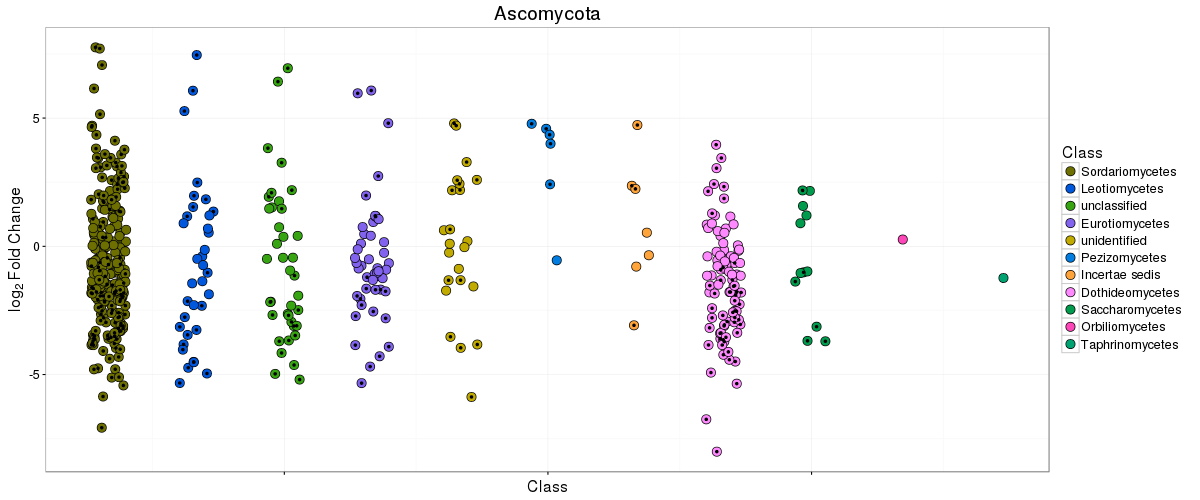

In [20]:
%%R -w 1200 -h 500
d = df.l2fc
FDR = 0.10

d = filter(d, Rank1 == 'k__Fungi', Rank2 == 'Ascomycota')
d$Rank3 = as.character(d$Rank3)
d$Rank3[is.na(d$Rank3)] = "unclassified"
d$Rank2[is.na(d$Rank2)] = "unclassified"

d$Rank4= factor(d$Rank3)

max.l2fc = ddply(d, .(Rank3), summarize, M = max(log2FoldChange))
d$Rank3 = factor(d$Rank3, max.l2fc[order(-max.l2fc$M),]$Rank3)

M = max(as.numeric(d$Rank3), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank3)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2


p = ggplot(d, aes(x = x.jitter, y = log2FoldChange, fill = Rank3))

p = p + geom_point(alpha = 1.00, shape = 21, size = 4)

p = p + scale_fill_manual(values = colors.1)

p = p + geom_point(data = subset(d, padj2 <= 0.10), fill = "black", shape = 21, size = 1)

#p = p + geom_hline(y = 1.3)

p = p + theme_bw()

p = p + theme(axis.text.x = element_blank())

p = p + labs(x = "Class", fill = "Class")

p = p + guides(col = guide_legend(ncol = 1))

p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(colour = guide_legend(override.aes = list(size=4)))  +
    theme(text = element_text(size=16)) + ggtitle('Ascomycota')


p

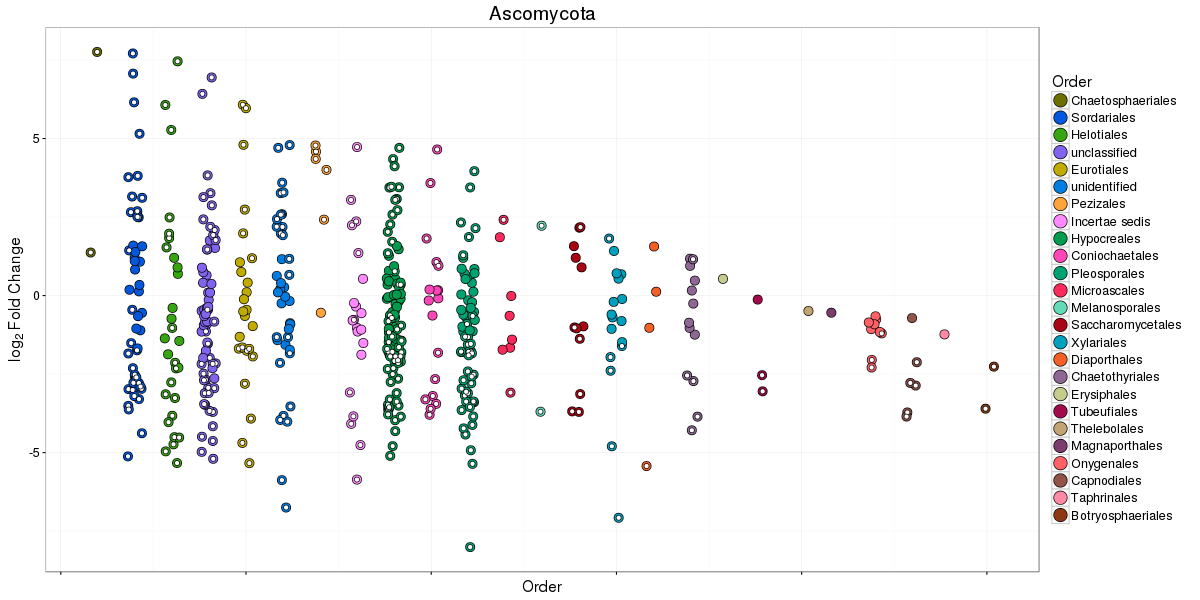

In [48]:
%%R -w 1200 -h 600
d = df.l2fc
FDR = 0.10

d = filter(d, Rank1 == 'k__Fungi', Rank2 == 'Ascomycota')
d$Rank4 = as.character(d$Rank4)
d$Rank4[is.na(d$Rank4)] = "unclassified"
d$Rank2[is.na(d$Rank2)] = "unclassified"

d$Rank4= factor(d$Rank4)

max.l2fc = ddply(d, .(Rank4), summarize, M = max(log2FoldChange))
d$Rank4 = factor(d$Rank4, max.l2fc[order(-max.l2fc$M),]$Rank4)

M = max(as.numeric(d$Rank4), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank4)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2


p = ggplot(d, aes(x = x.jitter, y = log2FoldChange, fill = Rank4))

p = p + geom_point(alpha = 1.00, shape = 21, size = 4)

p = p + scale_fill_manual(values = colors.1)

p = p + geom_point(data = subset(d, padj2 <= 0.10), fill = "white", shape = 21, size = 2)

#p = p + geom_hline(y = 1.3)

p = p + theme_bw()

p = p + theme(axis.text.x = element_blank())

p = p + labs(x = "Order", fill = "Order")


p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(fill = guide_legend(override.aes = list(size=6), ncol = 1))  +
    theme(text = element_text(size=16)) + ggtitle('Ascomycota')


p

In [49]:
%%R
ggsave('data/figs/Till_AscosLFC.jpg', width = 12, height = 8)

In [22]:
%%R
ggsave(filename = "data/figs/Till_OTUs_Ascos.jpg", plot = p, width =12, height =8)

In [23]:
%%R
test = d %>% group_by(Rank4) %>% filter(padj2 <=0.10) %>% mutate(ntax = n()) %>% group_by(Rank4, Till, ntax) %>%
        summarise(resp = n()) 

test = test %>% select(Rank4, Till, resp, ntax)
test$total = (test$resp/test$ntax)
test %>% as.data.frame

               Rank4 Till resp ntax     total
1  Chaetosphaeriales    T    2    2 1.0000000
2        Sordariales    N   20   33 0.6060606
3        Sordariales    T   13   33 0.3939394
4         Helotiales    N   13   20 0.6500000
5         Helotiales    T    7   20 0.3500000
6       unclassified    N   24   36 0.6666667
7       unclassified    T   12   36 0.3333333
8         Eurotiales    N    9   15 0.6000000
9         Eurotiales    T    6   15 0.4000000
10      unidentified    N   10   24 0.4166667
11      unidentified    T   14   24 0.5833333
12         Pezizales    T    5    5 1.0000000
13    Incertae sedis    N    6   11 0.5454545
14    Incertae sedis    T    5   11 0.4545455
15       Hypocreales    N   42   59 0.7118644
16       Hypocreales    T   17   59 0.2881356
17    Coniochaetales    N    7   12 0.5833333
18    Coniochaetales    T    5   12 0.4166667
19      Pleosporales    N   33   39 0.8461538
20      Pleosporales    T    6   39 0.1538462
21      Microascales    N    1    

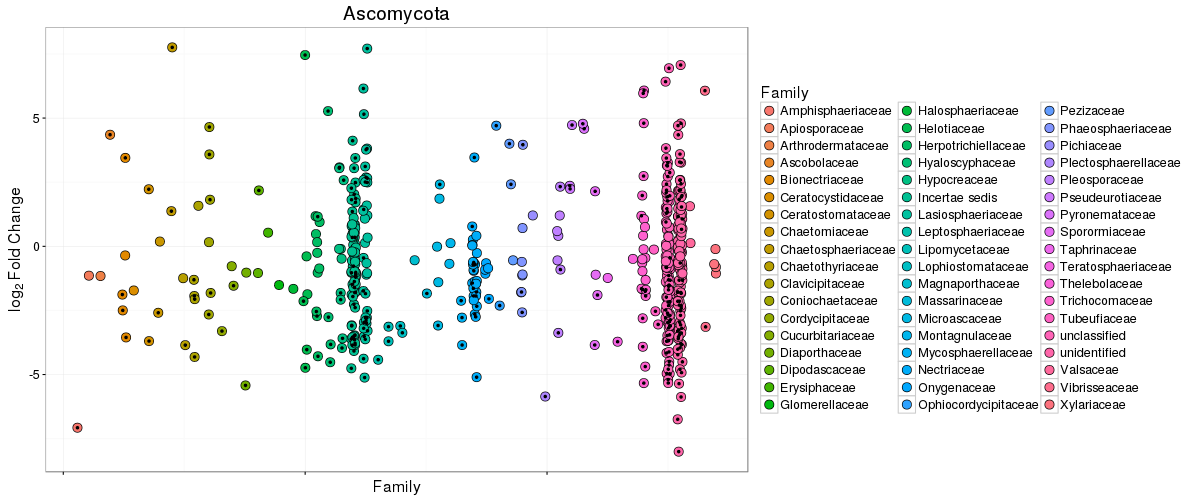

In [24]:
%%R -w 1200 -h 500
d = df.l2fc
FDR = 0.10

d = filter(d, Rank1 == 'k__Fungi', Rank2 == 'Ascomycota')
d$Rank5 = as.character(d$Rank5)
d$Rank5[is.na(d$Rank5)] = "unclassified"
d$Rank2[is.na(d$Rank2)] = "unclassified"

d$Rank5= factor(d$Rank5)

max.l2fc = ddply(d, .(Rank5), summarize, M = max(log2FoldChange))
d$Rank4 = factor(d$Rank5, max.l2fc[order(-max.l2fc$M),]$Rank5)

M = max(as.numeric(d$Rank5), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank5)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2


p = ggplot(d, aes(x = x.jitter, y = log2FoldChange, fill = Rank5))

p = p + geom_point(alpha = 1.00, shape = 21, size = 4)

#p = p + scale_fill_manual(values = colors.1)

p = p + geom_point(data = subset(d, padj2 <= 0.10), fill = "black", shape = 21, size = 1)

#p = p + geom_hline(y = 1.3)

p = p + theme_bw()

p = p + theme(axis.text.x = element_blank())

p = p + labs(x = "Family", fill = "Family")

p = p + guides(col = guide_legend(ncol = 1))

p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(colour = guide_legend(override.aes = list(size=4)))  +
    theme(text = element_text(size=16)) + ggtitle('Ascomycota')


p

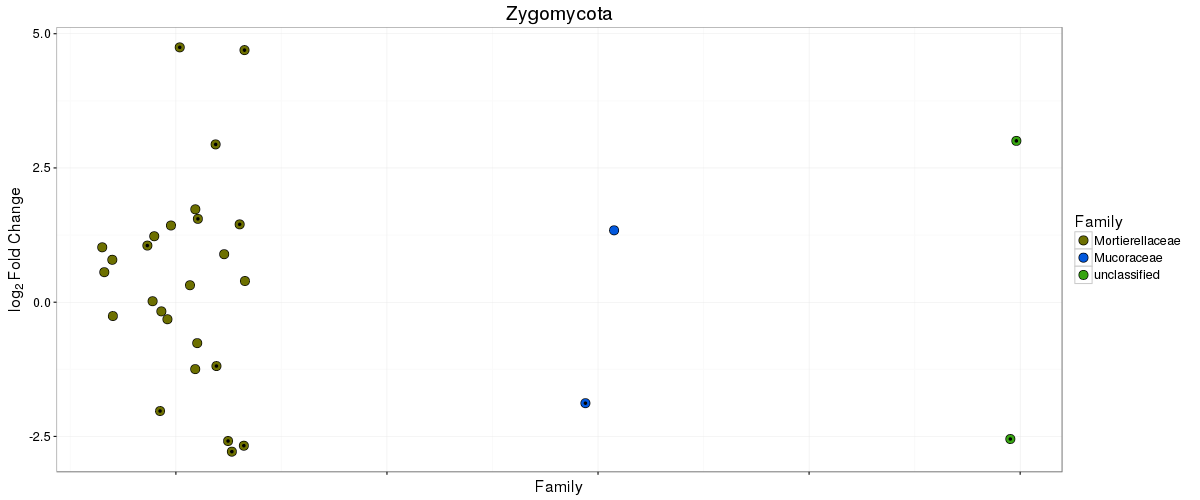

In [25]:
%%R -w 1200 -h 500
d = df.l2fc
FDR = 0.10

d = filter(d, Rank1 == 'k__Fungi', Rank2 == 'Zygomycota')
d$Rank5 = as.character(d$Rank5)
d$Rank5[is.na(d$Rank5)] = "unclassified"
d$Rank2[is.na(d$Rank2)] = "unclassified"

d$Rank5= factor(d$Rank5)

max.l2fc = ddply(d, .(Rank5), summarize, M = max(log2FoldChange))
d$Rank4 = factor(d$Rank5, max.l2fc[order(-max.l2fc$M),]$Rank5)

M = max(as.numeric(d$Rank5), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank5)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2


p = ggplot(d, aes(x = x.jitter, y = log2FoldChange, fill = Rank5))

p = p + geom_point(alpha = 1.00, shape = 21, size = 4)

p = p + scale_fill_manual(values = colors.1)

p = p + geom_point(data = subset(d, padj2 <= 0.10), fill = "black", shape = 21, size = 1)

#p = p + geom_hline(y = 1.3)

p = p + theme_bw()

p = p + theme(axis.text.x = element_blank())

p = p + labs(x = "Family", fill = "Family")

p = p + guides(col = guide_legend(ncol = 1))

p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(colour = guide_legend(override.aes = list(size=4)))  +
    theme(text = element_text(size=16)) + ggtitle('Zygomycota')


p

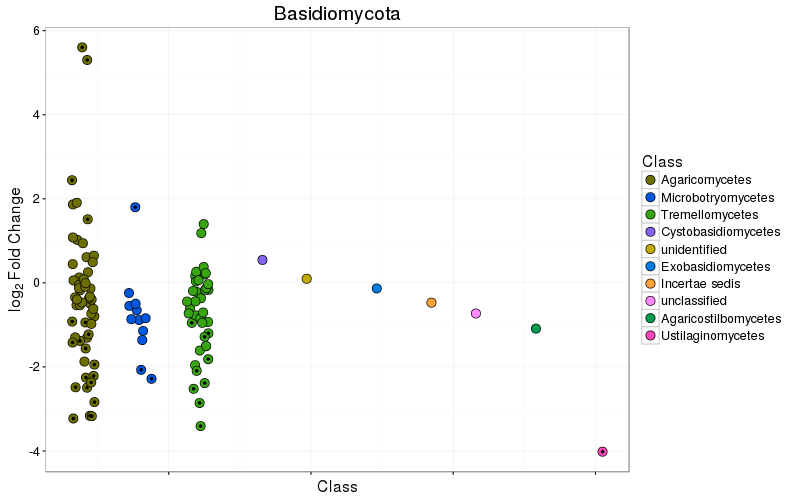

In [26]:
%%R -w 800 -h 500
d = df.l2fc
FDR = 0.10

d = filter(d, Rank1 == 'k__Fungi', Rank2 == 'Basidiomycota')
d$Rank3 = as.character(d$Rank3)
d$Rank3[is.na(d$Rank3)] = "unclassified"
d$Rank2[is.na(d$Rank2)] = "unclassified"

d$Rank4= factor(d$Rank3)

max.l2fc = ddply(d, .(Rank3), summarize, M = max(log2FoldChange))
d$Rank3 = factor(d$Rank3, max.l2fc[order(-max.l2fc$M),]$Rank3)

M = max(as.numeric(d$Rank3), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank3)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2


p = ggplot(d, aes(x = x.jitter, y = log2FoldChange, fill = Rank3))

p = p + geom_point(alpha = 1.00, shape = 21, size = 4)

p = p + scale_fill_manual(values = colors.1)

p = p + geom_point(data = subset(d, padj2 <= 0.10), fill = "black", shape = 21, size = 1)

#p = p + geom_hline(y = 1.3)

p = p + theme_bw()

p = p + theme(axis.text.x = element_blank())

p = p + labs(x = "Class", fill = "Class")

p = p + guides(col = guide_legend(ncol = 1))

p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(colour = guide_legend(override.aes = list(size=4)))  +
    theme(text = element_text(size=16)) + ggtitle('Basidiomycota')


p

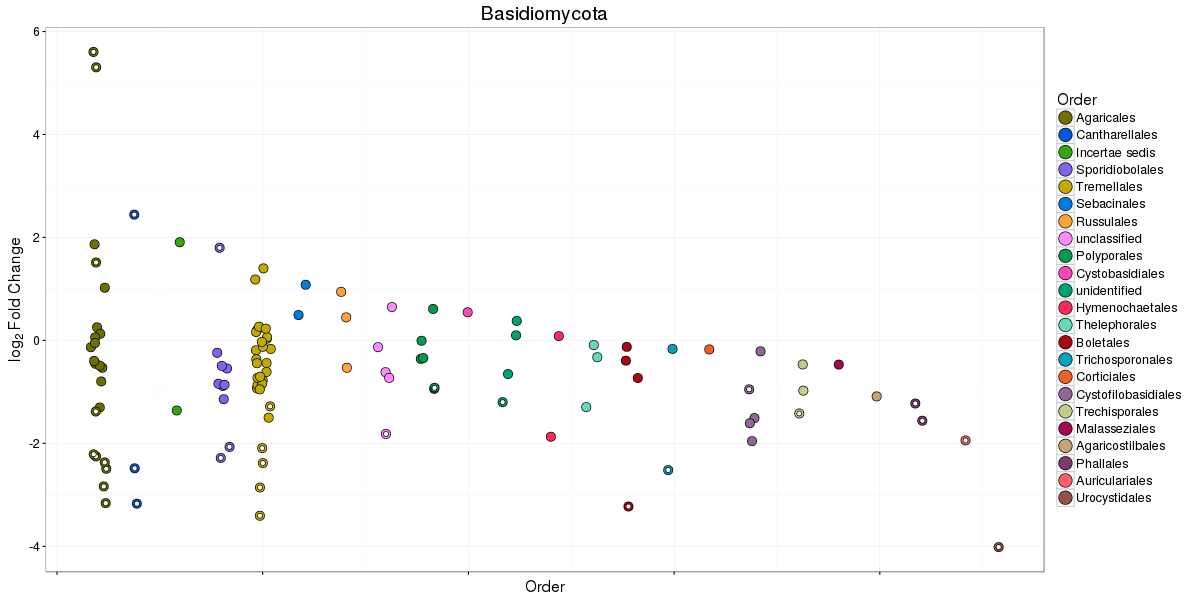

In [50]:
%%R -w 1200 -h 600
d = df.l2fc
FDR = 0.10

d = filter(d, Rank1 == 'k__Fungi', Rank2 == 'Basidiomycota')
d$Rank4 = as.character(d$Rank4)
d$Rank4[is.na(d$Rank4)] = "unclassified"
d$Rank2[is.na(d$Rank2)] = "unclassified"

d$Rank4= factor(d$Rank4)

max.l2fc = ddply(d, .(Rank4), summarize, M = max(log2FoldChange))
d$Rank4 = factor(d$Rank4, max.l2fc[order(-max.l2fc$M),]$Rank4)

M = max(as.numeric(d$Rank4), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank4)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2


p = ggplot(d, aes(x = x.jitter, y = log2FoldChange, fill = Rank4))

p = p + geom_point(alpha = 1.00, shape = 21, size = 4)

p = p + scale_fill_manual(values = colors.1)

p = p + geom_point(data = subset(d, padj2 <= 0.10), fill = "white", shape = 21, size = 2)

#p = p + geom_hline(y = 1.3)

p = p + theme_bw()

p = p + theme(axis.text.x = element_blank())

p = p + labs(x = "Order", fill = "Order")


p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(fill = guide_legend(override.aes = list(size= 6), ncol = 1))  +
    theme(text = element_text(size=16)) + ggtitle('Basidiomycota')


p

In [51]:
%%R
ggsave(filename = "data/figs/Till_OTUs_Basidios.jpg", plot = p, width =12, height =8)

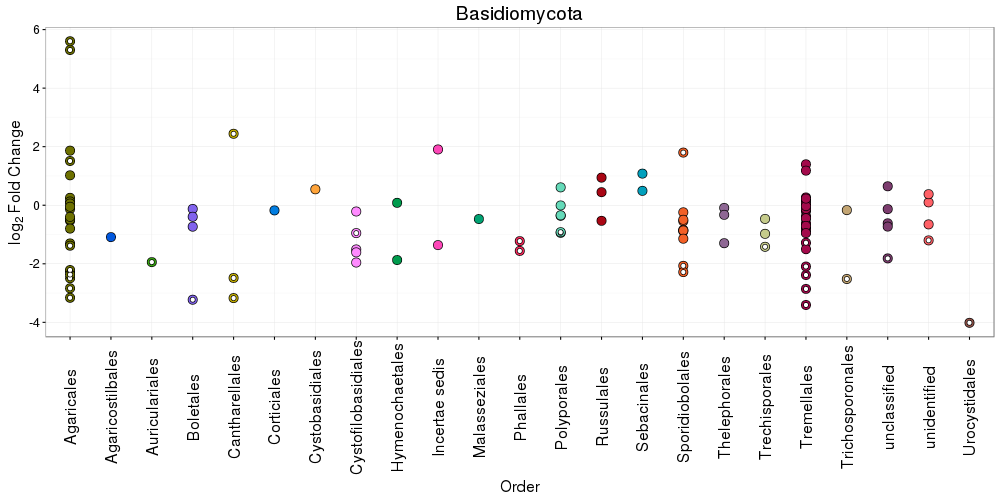

In [29]:
%%R -w 1000 -h 500
d = df.l2fc
FDR = 0.10

d = filter(d, Rank1 == 'k__Fungi', Rank2 == 'Basidiomycota')
d$Rank4 = as.character(d$Rank4)
d$Rank4[is.na(d$Rank4)] = "unclassified"
d$Rank2[is.na(d$Rank2)] = "unclassified"

d$Rank4= factor(d$Rank4)

max.l2fc = ddply(d, .(Rank4), summarize, M = max(log2FoldChange))
d$Rank3 = factor(d$Rank4, max.l2fc[order(-max.l2fc$M),]$Rank4)

M = max(as.numeric(d$Rank4), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank4)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2


p = ggplot(d, aes(x = Rank4, y = log2FoldChange, fill = Rank4))

p = p + geom_point(alpha = 1.00, shape = 21, size = 4)

p = p + scale_fill_manual(values = colors.1)

p = p + geom_point(data = subset(d, padj2 <= 0.10), fill = "white", shape = 21, size = 2)

#p = p + geom_hline(y = 1.3)

p = p + theme_bw()

p = p + theme(axis.text.x = element_blank())

p = p + labs(x = "Order", fill = "Order")

p = p + guides(col = guide_legend(ncol = 1))

p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(colour = guide_legend(override.aes = list(size=4)))  +
    theme(text = element_text(size=16), axis.text.x  = element_text(angle=90, vjust=0.5, size=16)) + 
    ggtitle('Basidiomycota') + guides(fill = FALSE)


p

In [30]:
%%R
levels(unique(d$Rank4))

 [1] "Agaricales"          "Agaricostilbales"    "Auriculariales"     
 [4] "Boletales"           "Cantharellales"      "Corticiales"        
 [7] "Cystobasidiales"     "Cystofilobasidiales" "Hymenochaetales"    
[10] "Incertae sedis"      "Malasseziales"       "Phallales"          
[13] "Polyporales"         "Russulales"          "Sebacinales"        
[16] "Sporidiobolales"     "Thelephorales"       "Trechisporales"     
[19] "Tremellales"         "Trichosporonales"    "unclassified"       
[22] "unidentified"        "Urocystidales"      


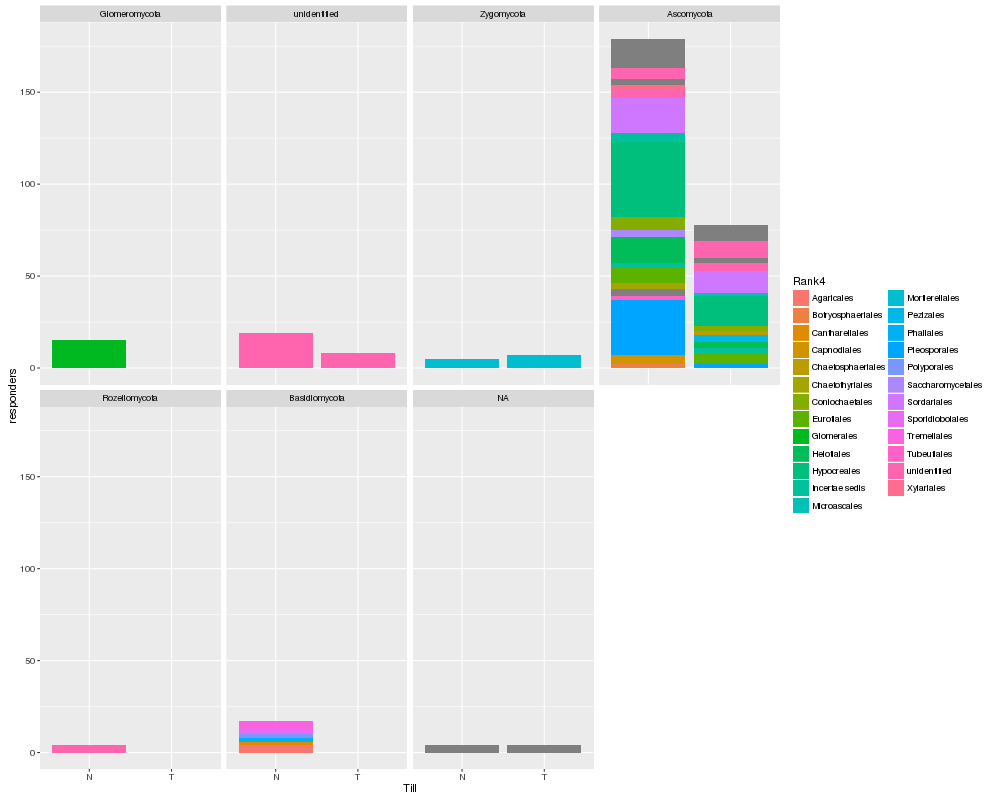

In [31]:
%%R -w 1000 -h 800
dcounts = df.l2fc %>%
          filter(!is.na(log2FoldChange)) %>%
          filter(!is.na(padj)) %>%
          group_by(Rank2, Rank3, Rank4, Rank5, Till) %>%
          summarize(responders = sum(padj<= 0.10))
dcounts = filter(dcounts, responders > 1)
dcounts$Rank2 = reorder(dcounts$Rank2, -dcounts$responders)


p = ggplot(dcounts, aes(x = Till , y = responders, fill = Rank4)) +
    geom_bar(stat = "identity") +
    facet_wrap( ~ Rank2, ncol = 4, nrow = 7) 

p

In [32]:
%%R
new_df.l2fc = df.l2fc
new_df.l2fc$Resp_status[new_df.l2fc$padj2 > 0.10] = "non-responder"
new_df.l2fc$Resp_status[new_df.l2fc$padj2 <= 0.10 & new_df.l2fc$log2FoldChange < 0] = "NT enriched"
new_df.l2fc$Resp_status[new_df.l2fc$padj2 <= 0.10 &  new_df.l2fc$log2FoldChange > 0] = "PT enriched"

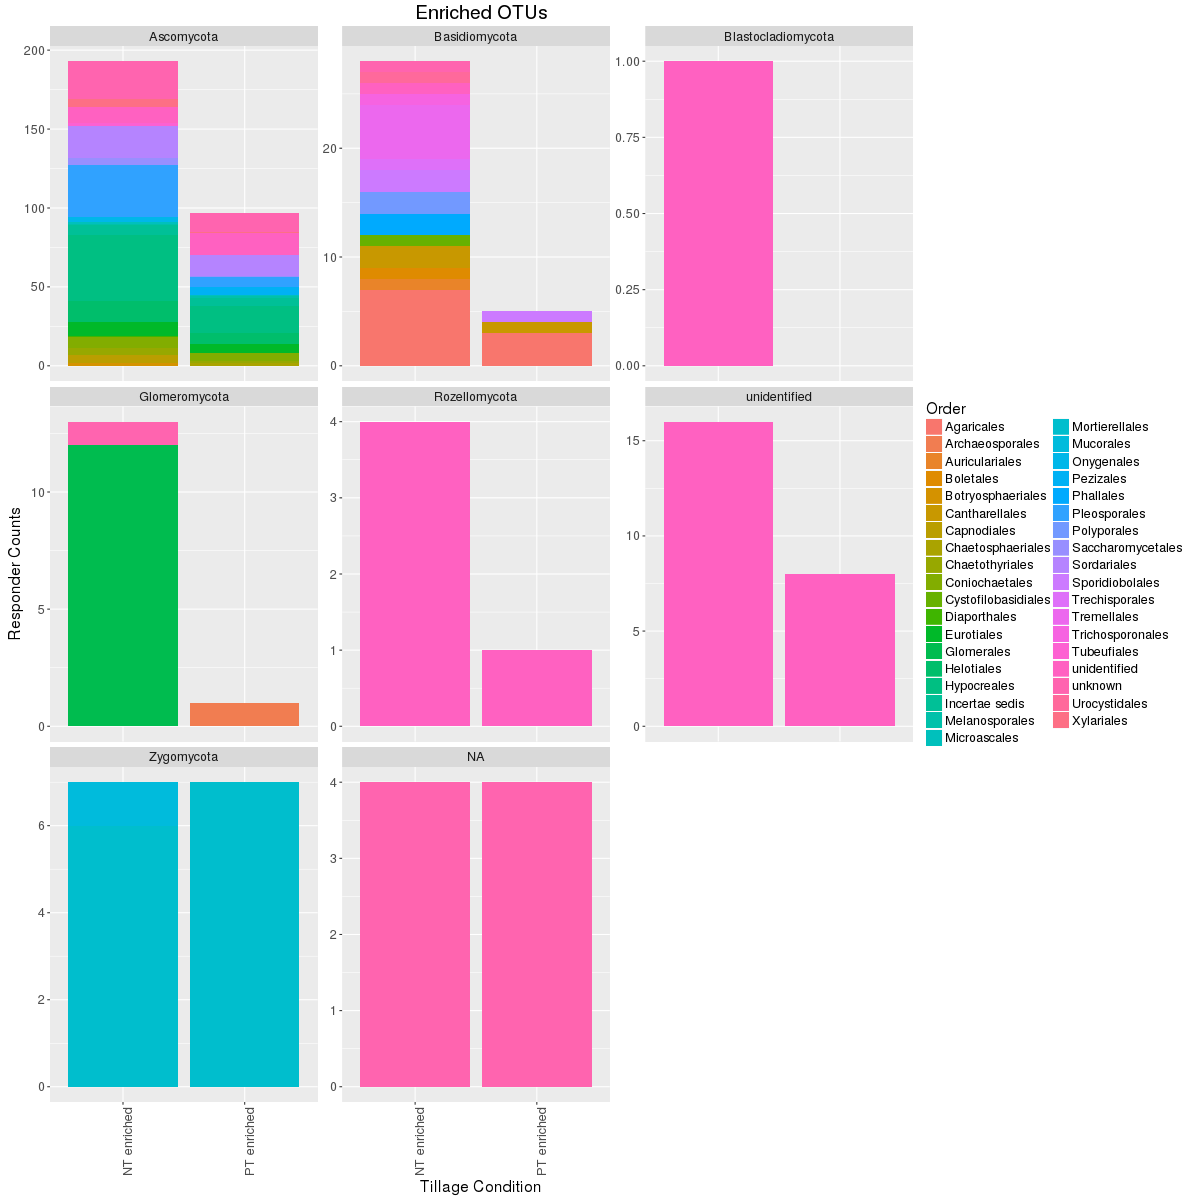

In [33]:
%%R -w 1200 -h 1200
dcounts = new_df.l2fc %>%
          filter(Resp_status %in% c("NT enriched", "PT enriched")) %>%
          group_by(OTU, Rank6, Rank5, Rank4, Rank3, Rank2, Resp_status) %>%
          summarize(responders = sum(padj2<= 0.10)) %>% ungroup() %>% arrange(Rank4)

dcounts$Rank4[is.na(dcounts$Rank4)] = "unknown"
dcounts$Rank5[is.na(dcounts$Rank5)] = "unknown"

dcounts$Rank4 = reorder(dcounts$Rank4, dcounts$Rank2)
#dcounts$Rank2 = reorder(dcounts$Rank2, -dcounts$responders)

p = ggplot(dcounts, aes(x = Resp_status , y = responders, fill = Rank4)) +
    geom_bar(stat = "identity") + #scale_x_discrete(breaks=NULL, name = NULL) +
    facet_wrap(~Rank2, scales = "free_y") +
    #scale_y_discrete(limits = (0, 50)) +
    ggtitle("Enriched OTUs") + ylab("Responder Counts")+
    xlab("Tillage Condition") + guides(fill=guide_legend(title='Order', ncol = 2)) +
    theme(text = element_text(size=16), axis.text.x = element_text(angle=90, vjust=1)) #+#, legend.position=c(2, 0.2)) +
   # scale_fill_manual(values = colors.1)


p

In [34]:
%%R
dcounts%>% group_by(Rank4, Resp_status, Rank2) %>% select(Rank4, Rank2, responders, Resp_status) %>% 
                summarise(totresp = sum(responders)) %>% ungroup %>% arrange(Rank2) %>% as.data.frame

                 Rank4 Resp_status              Rank2 totresp
1    Botryosphaeriales NT enriched         Ascomycota       2
2          Capnodiales NT enriched         Ascomycota       5
3    Chaetosphaeriales PT enriched         Ascomycota       2
4      Chaetothyriales NT enriched         Ascomycota       4
5      Chaetothyriales PT enriched         Ascomycota       1
6       Coniochaetales NT enriched         Ascomycota       7
7       Coniochaetales PT enriched         Ascomycota       5
8         Diaporthales NT enriched         Ascomycota       1
9           Eurotiales NT enriched         Ascomycota       9
10          Eurotiales PT enriched         Ascomycota       6
11          Helotiales NT enriched         Ascomycota      13
12          Helotiales PT enriched         Ascomycota       7
13         Hypocreales NT enriched         Ascomycota      42
14         Hypocreales PT enriched         Ascomycota      17
15      Incertae sedis NT enriched         Ascomycota       6
16      

In [35]:
%%R
ggsave(filename = "data/figs/TillEnriched_byOrder.jpg", plot = p, width =20, height =14)

In [36]:
%%R
filter(dcounts, Rank2 == 'Cyanobacteria') %>% as.data.frame

[1] OTU         Rank6       Rank5       Rank4       Rank3       Rank2      
[7] Resp_status responders 
<0 rows> (or 0-length row.names)


In [37]:
%%R
length(unique(dcounts$Rank3))

[1] 14


In [38]:
%%R
colors = c("#F076F9",
"#3BF853",
"#8944B9",
"#93FB3B",
"#8C166F",
"#3CF397",
"#F63923",
"#2BFBD8",
"#B50F34",
"#7AF0EB",
"#D66E00",
"#579EFB",
"#A4CF32",
"#3E69C7",
"#E4F27B",
"#191D3B",
"#B2F8AB",
"#F15976",
"#38801A",
"#EE8BD6",
"#555415",
"#2F93C9",
"#EF8786",
"#142010",
"#F075AB",
"#0E4442",
"#F1B69C",
"#28507C",
"#CDCDE8")

In [39]:
%%R -w 1200 -h 1200
Resp.to.keep = new_df.l2fc %>% group_by(Rank2, Resp_status) %>% summarise(Resp = sum(padj2<= 0.10)) %>% filter(Resp > 2)

dcounts.filt = filter(dcounts, Rank2 %in% Resp.to.keep$Rank2)

dcounts.filt$Rank3 = reorder(dcounts.filt$Rank3, -dcounts.filt$responders)
dcounts.filt$Rank2 = reorder(dcounts.filt$Rank2, -dcounts.filt$responders)


p = ggplot(dcounts.filt, aes(x = Resp_status , y = responders, fill = Rank4)) +
    geom_bar(stat = "identity") + #scale_x_discrete(breaks=NULL, name = NULL) +
    facet_wrap(~Rank2, scales = "free_y") +
    #scale_y_discrete(limits = (0, 50)) +
    ggtitle("Enriched OTUs") + ylab("Responder Counts")+
   xlab("Tillage Condition") + guides(fill=guide_legend(title='Order', ncol = 2)) +
    theme(text = element_text(size=16), axis.text.x = element_text(angle=90, vjust=1)) +#, legend.position=c(2, 0.2)) +
    scale_fill_manual(values = colors.1)



p

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error: Insufficient values in manual scale. 37 needed but only 25 provided.

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: In addition: 
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: There were 38 warnings (use warnings() to see them)
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 

  res = super(Function, self).__call__(*new_args, **new_kwargs)


RRuntimeError: Error: Insufficient values in manual scale. 37 needed but only 25 provided.


In [ ]:
%%R
ggsave(filename = "data/figs/TillEnriched_byOrder_filt.jpg", plot = p, width =20, height =14)

In [ ]:
%%R
length(unique(d.counts.filt$Rank3))

In [ ]:
%%R
head(df.l2fc)

In [ ]:
%%R
new_df.l2fc = df.l2fc
new_df.l2fc$Resp_status[new_df.l2fc$padj2 <=0.10 & new_df.l2fc$log2FoldChange > 0] = 'T Enriched'
new_df.l2fc$Resp_status[new_df.l2fc$padj <= 0.10 & new_df.l2fc$log2FoldChange < 0] = 'NT Enriched'
new_df.l2fc$Resp_status[new_df.l2fc$padj > 0.10] = 'Not Enriched'



head(new_df.l2fc)

In [ ]:
%%R -w 1200 -h 1200
d = filter(new_df.l2fc, padj2 <=0.10)#, 'Relative Abundance' > 0)
d = filter(d, Rank2 %in% dcounts.filt$Rank2)

p = ggplot(d, aes(log2FoldChange, Rank2))
p = p + geom_jitter(aes(color = Rank4), size = 2.5, height = 0.8, alpha = 0.5)
#p = p + facet_wrap(~Rank2, scales = 'free_y')
#p = p + xlab("RNA log2-fold change") + ylab("DNA log2-fold change")
p = p + scale_colour_discrete((name="Responder Status"))
p = p + ylab("Phylum") + theme_bw()

p = p + guides(color=guide_legend(title='Order', ncol = 2)) +
    theme(text = element_text(size=16), axis.text.x = element_text(angle=90, vjust=1)) +#, legend.position=c(2, 0.2)) +
    scale_color_manual(values = colors.1) 
p

In [ ]:
%%R
ggsave(plot = p, filename = 'data/figs/l2fc_phylum_class.jpg', height = 14, width = 20)

In [ ]:
%%R -w 600 -h 2000


phyla = unique((d.counts.filt$Rank2))

d = filter(new_df.l2fc, padj2 <=0.10)#, 'Relative Abundance' > 0)

plot = function(r, d) {
    plot.d = d %>% filter(Rank2 == r)
    #colors = scheme$hex(length(unique(plot.d$OTU)), color_space = hcl_presets$intense)

   p = ggplot(plot.d, aes(as.numeric(log2FoldChange), Rank3))
    p = p + geom_point(aes(color = Resp_status))
    p = p + scale_colour_discrete((name="Responder Status"))
    p = p + ylab("Class")
    p = p + theme_bw()
    p = p + xlim(-4, 6)
    
    p = p + theme(axis.text = element_text(size = 12),
                  legend.key.height = unit(0.65, "lines"),
                  legend.key.width = unit(0.65, "lines"),
                  legend.text = element_text(size = 9), axis.text.y  = element_text(angle=60, vjust=0.5, size=8)) 

        p = p + ggtitle(r)


    p}
    
plots.13CCPS = lapply(phyla, plot, d = d)

do.call(grid.arrange, c(plots.13CCPS,list(ncol=1)))

In [ ]:
%%R -w 600 -h 2000


phyla = unique((d.counts.filt$Rank2))

d = filter(new_df.l2fc, padj2 <=0.10)#, 'Relative Abundance' > 0)

plot = function(r, d) {
    plot.d = d %>% filter(Rank2 == r)
    #colors = scheme$hex(length(unique(plot.d$OTU)), color_space = hcl_presets$intense)

   p = ggplot(plot.d, aes(as.numeric(log2FoldChange), Rank3, fill = Rank4))
    p = p + geom_point()
    p = p + scale_colour_discrete((name="Responder Status"))
    p = p + ylab("Class")
    p = p + theme_bw()
    p = p + xlim(-4, 6)
    
    p = p + theme(axis.text = element_text(size = 12),
                  legend.key.height = unit(0.65, "lines"),
                  legend.key.width = unit(0.65, "lines"),
                  legend.text = element_text(size = 9), axis.text.x  = element_text(angle=90, vjust=0.5, size=10)) 

        p = p + ggtitle(r)


    p}
    
plots.13CCPS = lapply(phyla, plot, d = d)

do.call(grid.arrange, c(plots.13CCPS,list(ncol=1)))